<a href="https://colab.research.google.com/github/kerem95reiz/DeepLearningPractice/blob/ipynb-studies/Mnist_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

if not (PATH/FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH/FILENAME).open('wb').write(content)

In [0]:
import pickle, gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')


(50000, 784)


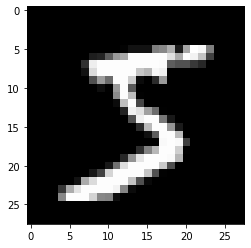

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape)

In [0]:
import torch
import torch.nn.functional as F
x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                         (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape
bs = 64
loss_func = F.cross_entropy

In [0]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [0]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin1(xb)

In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  return loss.item(), len(xb)

In [0]:
def get_data(train_ds, valid_ds, bs):
  return (
      DataLoader(train_ds, batch_size=bs, shuffle=2),
      DataLoader(valid_ds, batch_size=bs*2)
  )

In [0]:
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

lr = 0.5
epochs = 2

def get_model():
  model = Mnist_Logistic()
  opt = optim.SGD(model.parameters(), lr=lr)
  return model, opt

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

      model.eval()
      with torch.no_grad():
        losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
    val_loss = np.multiply(losses, nums) / np.sum(nums)
    print(epoch, val_loss)

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)


In [0]:
# Training tek katman ile model egitme
model, opt = get_model()
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
# fit(epochs, model, loss_func, opt, train_dl, valid_dl)

In [0]:
# Bi CNN ile model egitme
class Mnist_CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

  def forward(self, xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, 4)
    xb = xb.view(-1, xb.size(1))
    return xb

lr = 0.1

model = Mnist_CNN()
opt = optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)
# fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Sequential sinfinin kullanilabilmesi icin, verilen butun parametrelerin bi Katman olmasi lazim ve bunun icinde bu pytorch'da kendiliginden katman olarak tanimlanmamis olan *view* fonksiyonunu bi katmanin icerisine yerlestiriyoruz.

In [0]:
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x):
    return self.func(x)

def preprocess(x):
  return x.view(-1, 1, 28, 28)

In [0]:
# Sequentiali kullanaraktan modeli egitme
model = nn.Sequential(
  Lambda(preprocess),
  nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.AvgPool2d(4),
  Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# fit(epochs, model, loss_func, opt, train_dl, valid_dl)